## Dive into Deep Learning 3.7 (Weight Decay)

In [35]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [36]:
class Data(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs)
        noise = torch.randn(n, 1) * 0.01
        w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = torch.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)

In [37]:
def l2_penalty(w):
    return (w ** 2).sum() / 2

In [38]:
class WeightDecayScratch(d2l.LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return (super().loss(y_hat, y) +
                self.lambd * l2_penalty(self.w))

In [39]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

L2 norm of w: 0.009992911480367184


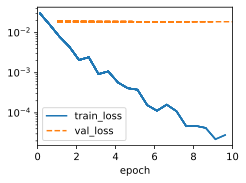

In [40]:
train_scratch(0)

L2 norm of w: 0.001471846830099821


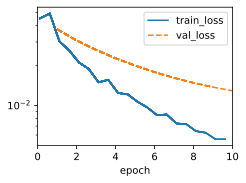

In [41]:
train_scratch(3)

In [42]:
class WeightDecay(d2l.LinearRegression):
    def __init__(self, wd, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.wd = wd

    def configure_optimizers(self):
        return torch.optim.SGD([
            {'params': self.net.weight, 'weight_decay': self.wd},
            {'params': self.net.bias}], lr=self.lr)

    def accuracy(self, y_hat, y):
        return 1 - (y_hat - y.reshape(y_hat.shape)) ** 2 / (y - y.mean()) ** 2

L2 norm of w: 0.014477514661848545


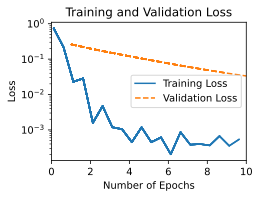

In [43]:
model = WeightDecay(wd=3, lr=0.01)
model.board.yscale='log'
trainer.fit(model, data)

print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))

plt.title('Training and Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')

legend_labels = ['Training Loss', 'Validation Loss']
legend_colors = ['#1f77b4', '#ff7f0e']
legend_handles = [
    Line2D([0], [0], linestyle='-', color=legend_colors[0]),
    Line2D([0], [0], linestyle='--', color=legend_colors[1])
]
plt.legend(legend_handles, legend_labels)
plt.show()

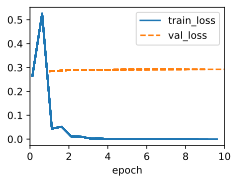

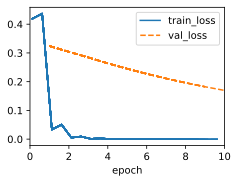

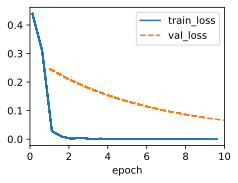

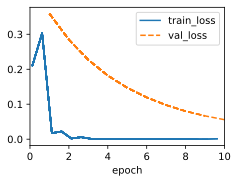

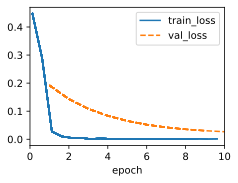

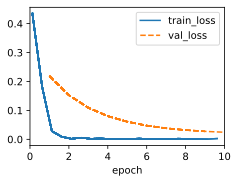

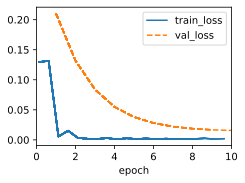

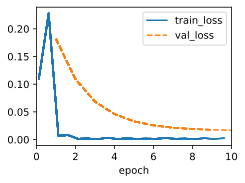

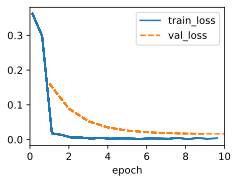

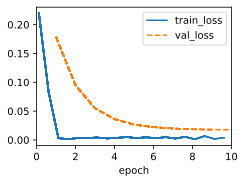

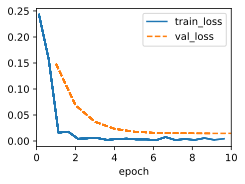

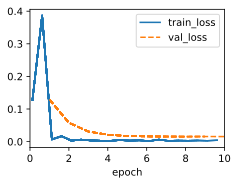

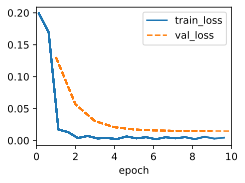

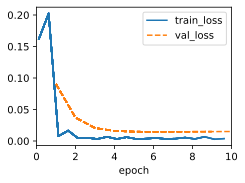

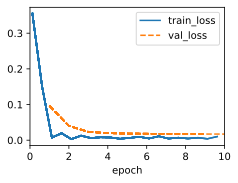

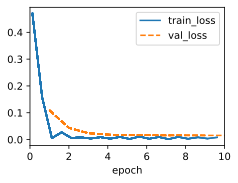

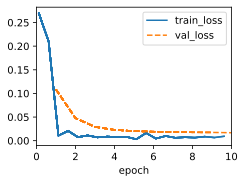

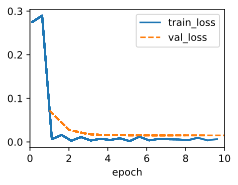

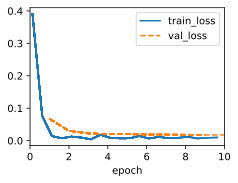

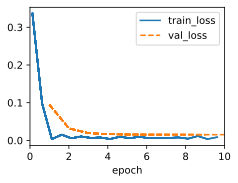

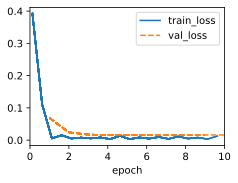

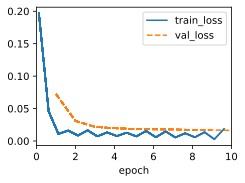

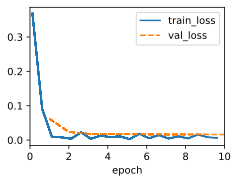

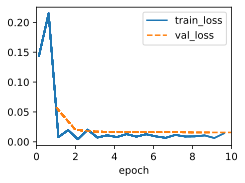

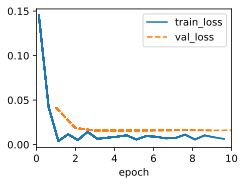

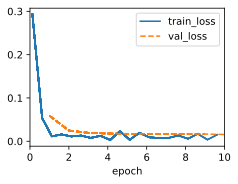

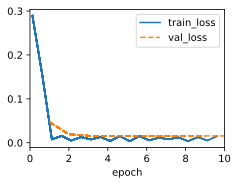

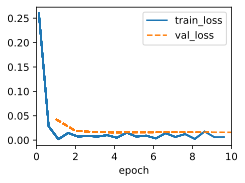

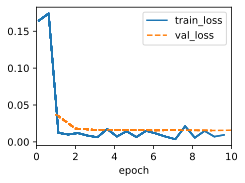

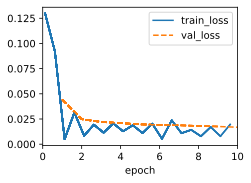

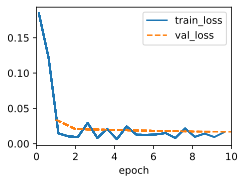

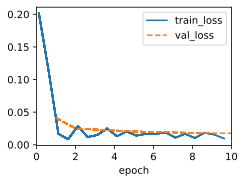

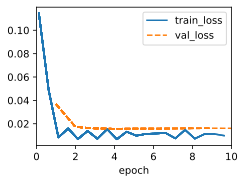

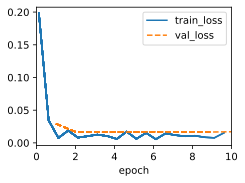

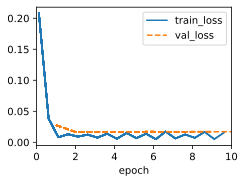

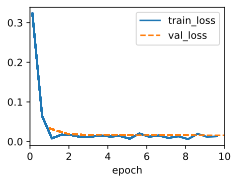

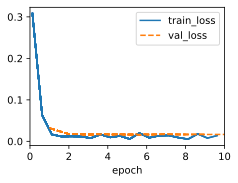

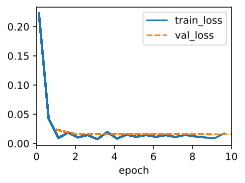

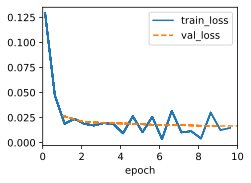

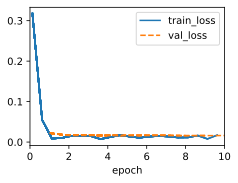

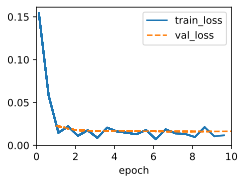

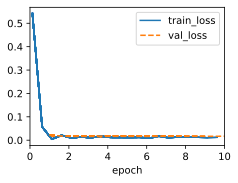

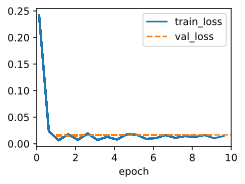

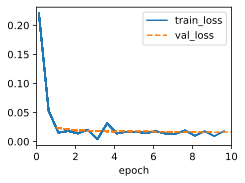

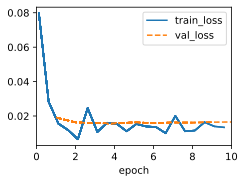

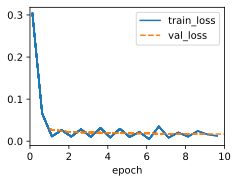

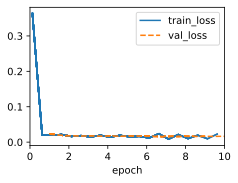

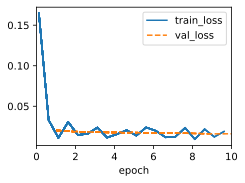

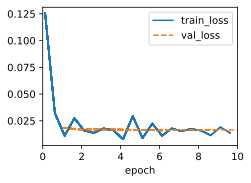

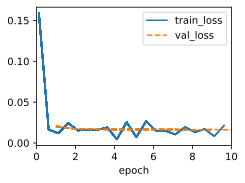

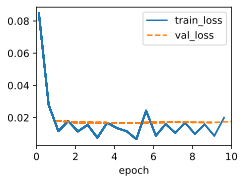

In [44]:
lambd_values = np.arange(0, 51, 1)

train_acc, val_acc = [], []
train_X, train_y = next(iter(data.get_dataloader(train=True)))
val_X, val_y = next(iter(data.get_dataloader(train=False)))

for lambd in lambd_values:
    model = WeightDecay(wd=lambd, lr=0.01)
    trainer.fit(model, data)

    train_pred = model(train_X).detach().numpy()
    val_pred = model(val_X).detach().numpy()

    # Compute accuracies
    train_acc.append(1 - ((train_pred - train_y.numpy()) ** 2 / 2).mean())
    val_acc.append(1 - ((val_pred - val_y.numpy()) ** 2 / 2).mean())

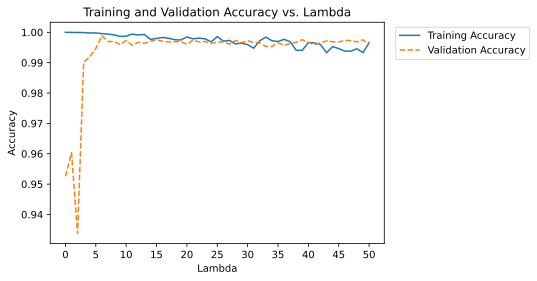

In [45]:
# Plot train_acc and val_acc against lambda
plt.figure(figsize=(6, 4))
plt.plot(lambd_values, train_acc, linestyle='-')
plt.plot(lambd_values, val_acc, linestyle='--')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0, 51, 5))
plt.title('Training and Validation Accuracy vs. Lambda')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper right', bbox_to_anchor=[1.45, 1])
plt.show()